# STDSR23 - Assignment-01

> Put your full name and surname, as well as Telegram alias and group number
> Voronov Roman
> Group DS21-02
> Alias: @porludom
> Realization of MRL98 with ["New algorithm" Collapse policy (Chapter 3.3)](https://www2.cs.sfu.ca/CourseCentral/741/jpei/readings/MRL98.pdf)

# Quantile implementation

February 2023

## Assignment description

* Obtain the research paper titled ["A Survey of Approximate Quantile Computation on Large-Scale Data"](https://arxiv.org/pdf/2004.08255.pdf)

* Select and implement one of the methods discussed in the paper, following good coding style and with appropriate comments. Your algorithm can be based on `BasicQuantileAlgorithm` class. In that case, your main implementation is in the `compute_quantile` function.
* Prepare a report that includes
    * A detailed explanation of the selected algorithm
    * A listing of the pros and cons of the chosen algorithm
* Test your implementation. More on that below in section `Test`.
* Submit Jupyter Notebook *.ipynb* to the Moodle

Note: Code style, comments, and overall organization of the report will be
taken into account in the grading process.


In [1]:
import math
import sys
import time
import numpy as np
import scipy as sp
from typing import List, Tuple

In [2]:
#Utility class for buffer of size k
class Buffer:
    def __init__(self, k, elements, level = None, isNull = True):
        self.k = k
        self.elements = elements
        self.isNull = isNull
        self.level = level
        self.weight = 0

In [3]:
def union(buffers, k):
    W = 0 # Total weight of the buffer
    all_elements = []
    pointers = []# pointers is the list of pointers for every buffer to iterate them

    for buffer in buffers:
        pointers.append(0) #every buffer will be iterated from 0
        W += buffer.weight

    total_length = k * len(buffers)

    for _ in range(total_length): # we should check every element in buffers after all
        min_value = np.Inf
        index_value = -1
        for i in range(len(buffers)): # for every element in all buffers we iterate over all first unchecked elements in buffers and pick the least one and then increment the corresponding pointer by 1
            #check that index is valid and
            if pointers[i] < k and min_value > buffers[i].elements[pointers[i]]:
                min_value = buffers[i].elements[pointers[i]]
                index_value = i
        all_elements.extend(buffers[index_value].weight * [buffers[index_value].elements[pointers[index_value]]])
        pointers[index_value] += 1 #one element checked

    return all_elements, W

#empty buffer
def new(buffer, elements, level):
    buffer.elements = elements
    buffer.elements.sort()
    buffer.weight = 1
    buffer.level = level
    buffer.isNull = False

def output(buffers, k, phi): #phi is quantile itself
    elements, W = union(buffers, k)
    return elements[math.ceil(phi*k*W)]

#Takes full buffers
def collapse(buffers, level, k):
    all_elements, w = union(buffers, k) #Get new weight and array of elements
    offset = (w + 1) // 2

    buffers[0].elements = [all_elements[j*w + offset] for j in range(k)] # first buffer is picked. fill by values
    buffers[0].level = level
    buffers[0].weight = w

    for i in range(1, len(buffers)): # null other buffers
        buffers[i].elements = []
        buffers[i].isNull = True
        buffers[i].level = None
        buffers[i].weight = 0

def get_k_random(k, n): # stream is based on normal distribution with mean=1000 and std=200
    if n>=k:
        return sp.stats.norm.rvs(loc=1000, scale=200, size=k)
    else: # Add equal number of +- infinities
        rvs = sp.stats.norm.rvs(loc=1000, scale=200, size=n)
        for i in range(k-n):
            rvs = np.append(rvs, np.Inf if i%2==0 else np.NINF)
        return rvs

#Now works for not every n, but for multiples of k
def start(b,k,phi, n):
    timeStart = time.time()
    buffers = [Buffer(k, []) for _ in range(b)] #empty set of k buffers
    all_elements = [] #to calculate error
    work = True
    space_takenByAlgo = 0
    while work:
        if n<=0:
            break
        l = np.inf
        empty_buffers = []

        for buffer in buffers:
            if buffer.isNull:
                empty_buffers.append(buffer)
            else:
                l = min(l, buffer.level)
        #here we should check how many empty buffers we have: 0, 1 or more (3 cases)
        if len(empty_buffers) == 0:
            same_buffers = [buffer for buffer in buffers if buffer.level == l]

            collapse(same_buffers, l+1, k)

        elif len(empty_buffers) == 1:
            cur_elements = get_k_random(k, n)
            all_elements.extend(cur_elements)
            n-=k # we read k elements

            new(empty_buffers[0], cur_elements, l)

        else: #a bunch of buckets
            for i in range(len(empty_buffers)):
                if n<=0: #if no elements left. We did this check before, but now we do more than one reading
                    work = False
                    break

                cur_elements = get_k_random(k, n)
                all_elements.extend(cur_elements)
                n-=k # we read k elements

                new(empty_buffers[i], cur_elements, 0)
        space_takenByAlgo = max(space_takenByAlgo, sys.getsizeof(buffers))


    full_buffers = [buffer for buffer in buffers if buffer.isNull == False]
    element = output(full_buffers, k, phi)
    time_takenByAlgo = time.time()-timeStart

    all_elements.sort()
    real_answer = np.quantile(all_elements, phi)
    error = abs(math.ceil((len(all_elements))*phi) - all_elements.index(element)) / len(all_elements) #use len since n is zero after the main process
    return element, real_answer, error, time_takenByAlgo, space_takenByAlgo, sys.getsizeof(all_elements)

# Test of accuracy

In [4]:
eps=0.1
n = 1900000
k = int(math.log2(2*n*eps)*0.5/eps)+1

elem, real_elem, err, timeByAlgo, spaceByAlgo, spaceByNp = start(4, k, 0.5, n)
print("Apr. answer: {}\nReal answer: {}\nError: {}\nTime taken by algorithm: {} sec\n"
      "Space taken by algorithm: {} bytes\n"
      "Space taken by saving all elements: {} bytes".format(elem, real_elem, err, timeByAlgo, spaceByAlgo,spaceByNp))

Apr. answer: 1001.5842973915682
Real answer: 999.9618320531554
Error: 0.0032577524244993506
Time taken by algorithm: 8.621888160705566 sec
Space taken by algorithm: 88 bytes
Space taken by saving all elements: 16555960 bytes


# Report
 I implemented the MRL98 algorithm with ["New algorithm" Collapse policy (Chapter 3.3)](https://www2.cs.sfu.ca/CourseCentral/741/jpei/readings/MRL98.pdf). The difference explained below.
 The goal of the algorithm is to reduce **space** consumption of calculating quantile for *huge* data stream. It is done by the cost of accuracy.
 According to [this source](https://www2.cs.sfu.ca/CourseCentral/741/jpei/readings/MRL98.pdf), algorithm must:
 1. not require prior knowledge of data distribution (met in algorithm)
 2. provide explicit and tunable error (done in algorithm)
 3. compute result in a single pass (done in this algorithm)
 4. use as little memory as possible (tunable and meetable in this algorithm)

and some other not so important for me now

# The principe of the algorithm
Algorithm spreads first coming data to **b** buckets of size **k**. When there are no buckets available, algorithm collapses some buckets using rules described below. Every bucket has weight. Weight means how many times every element in the bucket presented in this bucket. When collapsing, resulting buckets gets aproximation of all buckets collapsing. More times element presented - more weight it has.

# Operations in algorithm
## New
This operation takes an empty buffer, elements, and put those elements in this buffer in sorted order setting the weight to **1**
## Collapse
Takes list of buffers as input, and in some way summarized them into one buffer. Other buffers get marked as empty. The procedure described on the picture below. Here we have example for b=3 buckets with k=5 size.

![title](collapse.png)

## Output
Performs collapse operation on all buffers and finds requested quantile from the final buffer. This operation called only once, while other to operations can be called many many times.

Those are the basic operations that can be performed in different ways. According to, again, [this source](https://www2.cs.sfu.ca/CourseCentral/741/jpei/readings/MRL98.pdf), there are at least 3 algorithms with different approaches to operate with big data stream using those 3 operations: **Munro and Paterson**, **Alsabti et.al.** and **New algorithm**. I chose the **New algorithm** due to its high performance in comparison to other. This comparison given below

![title](comparison.png)
**New algorithm** expands the collapse operation. Now it also do some job with so called **levels**. Each buffer has its own level. Below given the description of how those levels work.

![title](levels.png)

# Cons and Pros
1. This algorithm optimizes space consumption the best way among other two algorithms. However, there are of course better more complicated algorithms.
2. There is an easy way to parallelize calculations
3. This algorithm requires prior knowledge of data stream size, as a pros

# Why this algorithm should know the size of the stream?
##### Because ideally we should specify k with accordance to error we want not to exceed. The formula is $$k\gt \frac{1}{2\epsilon}\log(2\epsilon N)$$
##### Also, as a result, since k depends on N, and space complexity of this algorithm depends on height of the logical tree and k. Both k and height depend on N, so space complexity also depends on N.


## Test and graphics of time and space consuming when increasing the stream size

Here you need to show that your algorithm is working properly.
1. Take `normal` distribution. Show, that with increase in sample size, quantiles calculated with your algorithms are become very close to the `inverse cdf` of the distribution. 

2. Perform the same experiment with any other continuous distribution (exponential, logistic, etc.)
3. (from previous deleted task cell) Compare time and space consuming

In [5]:
import matplotlib.pyplot as plt
timesAlgo = []
spacesAlgo = []
spacesNp = []
answers = []
eps = 0.01
for degree in range(3, 8):
    n = 10**degree
    k = int(math.log2(2*n*eps)*0.5/eps)+1
    elem, real_elem, err, timeByAlgo, spaceByAlgo, spaceByNp = start(5, k, 0.5, n)
    timesAlgo.append(timeByAlgo)
    spacesAlgo.append(spaceByAlgo)
    spacesNp.append(spaceByNp)
    answers.append(elem)


Text(0, 0.5, 'Time taken , sec')

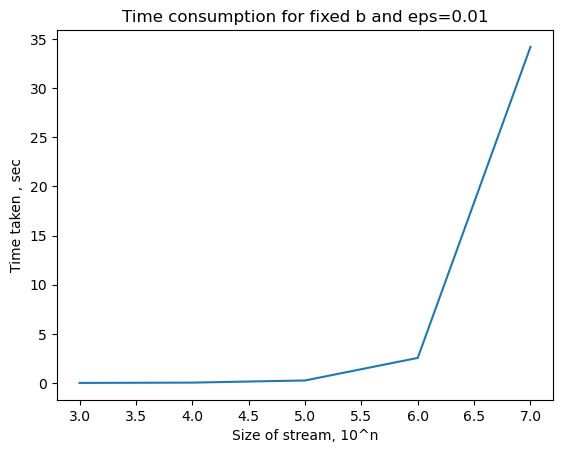

In [6]:
from operator import add
plt.plot(range(3,8), timesAlgo)
plt.title("Time consumption for fixed b and eps=0.01")
plt.xlabel("Size of stream, 10^n")
plt.ylabel("Time taken , sec")

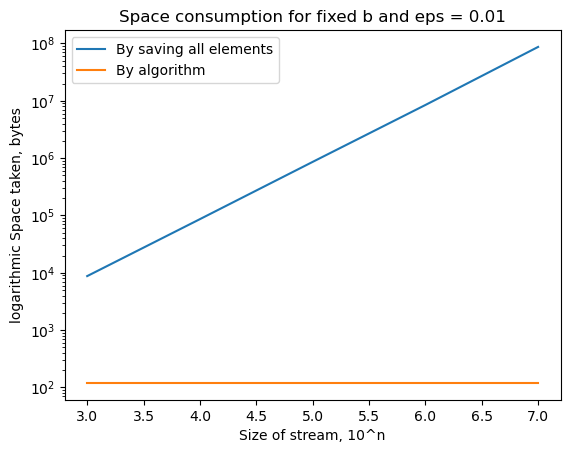

In [7]:
plt.plot(range(3,8), spacesNp)
plt.plot(range(3,8), spacesAlgo)
plt.legend(["By saving all elements", "By algorithm"])
plt.title("Space consumption for fixed b and eps = 0.01")
plt.xlabel("Size of stream, 10^n")
plt.ylabel("logarithmic Space taken, bytes")
plt.yscale("log")

Text(0, 0.5, 'Answer')

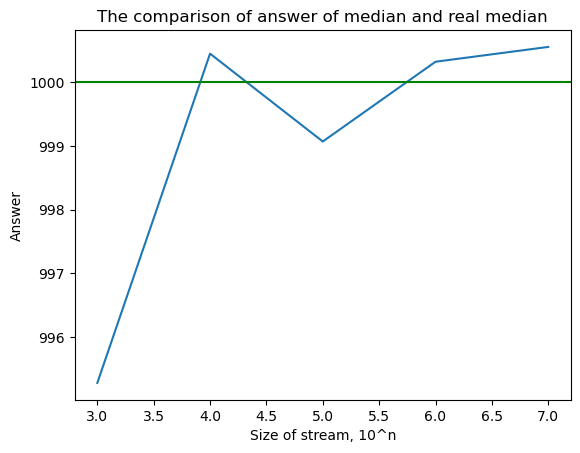

In [8]:
plt.plot(range(3,8), answers)
plt.axhline(1000, c = "green")
plt.title("The comparison of answer of median and real median")
plt.xlabel("Size of stream, 10^n")
plt.ylabel("Answer")

We see that algorithm takes a lot of time in comparison to just sort elements in list and find quantile by NumPy, but space that we saved is more than just huge.
Also, it has a pretty small error when size of the stream is higher than 10^4. Note, that coefficients b and k chosen to be pretty little and constant (b = 5, k = 500), so when increasing number of elements more and more, we will get a little bit higher error, but as we see, so little error(less than 1%) when we used 10000 times less space is awesome!

Now I`m going to do the same action but other distribution. It chosen to be binomial with n=1000, p = 0.2. Thus, median is 200.

In [9]:
def get_k_random(k, n): # stream now is based on binomial distribution with n=1000, p=0.2
    if n>=k:
        return sp.stats.binom.rvs(n=1000, p = 0.2, size=k)
    else: # Add equal number of +- infinities
        rvs = sp.stats.binom.rvs(n=1000, p = 0.2, size=n)
        for i in range(k-n):
            rvs = np.append(rvs, np.Inf if i%2==0 else np.NINF)
        return rvs

In [10]:
answers = []
for degree in range(3, 8):
    n = 10**degree
    k = int(math.log2(2*n*eps)*0.5/eps)+1
    elem, real_elem, err, timeByAlgo, spaceByAlgo, spaceByNp = start(5, k, 0.5, n)
    answers.append(elem)

Text(0, 0.5, 'Answer')

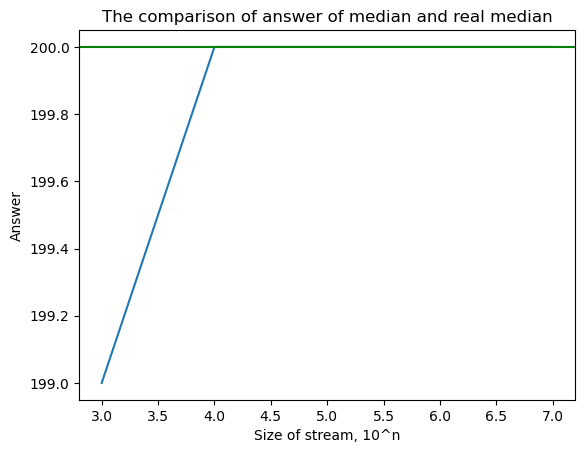

In [11]:
plt.plot(range(3,8), answers)
plt.axhline(200, c = "green")
plt.title("The comparison of answer of median and real median")
plt.xlabel("Size of stream, 10^n")
plt.ylabel("Answer")

In [12]:
answers

[199, 200, 200, 200, 200]